In [1]:
import statsmodels.stats.proportion as ssp
import itertools
import math
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import matplotlib as mplt
from adjustText import adjust_text
import statsmodels.stats.proportion
pd.options.mode.chained_assignment = None
import matplotlib.colors as colors_mplt

Functions

In [94]:
def read_model_xy(g):
    '''Return dictionary with model params and xy coordinates for given group'''
    model_params = pd.read_csv("../scripts/pgls_res/{}.model_params.tsv".format(g),sep="\t")
    xy_data = pd.read_csv("../scripts/pgls_res/{}.xy_data.tsv".format(g),sep="\t")
    return model_params, xy_data

def identity_line(ax=None, ls='--', *args, **kwargs):
    '''Draws identity line'''
    ax = ax or plt.gca()
    identity, = ax.plot([], [], ls=ls, *args, **kwargs)
    def callback(axes):
        low_x, high_x = ax.get_xlim()
        low_y, high_y = ax.get_ylim()
        low = min(low_x, low_y)
        high = max(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(ax)
    ax.callbacks.connect('xlim_changed', callback)
    ax.callbacks.connect('ylim_changed', callback)
    return ax

def plot_pgls(data, g, experiment, pgls, ax, color, scatter, alpha, line, label_legend):
    '''Plots experiment vs. X(Z)/A alpha in group g to ax,
    also returns dict with lambda, r2 and pval'''

    # Get params into dict, then get pertinent stats
    param_df = data[g]["params"]
    params = list(param_df[param_df.experiment==experiment].transpose().to_dict().values())[0]
    slope = params["{}_slope".format(pgls)]
    intercept = params["{}_intercept".format(pgls)]
    lambda_val = params["ml_lambda"]
    r2 = params["{}_rsq".format(pgls)]
    p = params["{}_pval".format(pgls)]
    
    # Get xy data
    xy_df = data[g]["xy"]
    xy = xy_df[xy_df.experiment==experiment].reset_index(drop=True)
    
    # Plot scatter and line
    label = ""
    if label_legend:
        label = "{}:\n".format(g) + r"$\lambda={:.2f}, p={:.3f}, r^2={:.2f}$".format(lambda_val, p, r2)
    if scatter:
        ax.scatter(xy["xvar"], xy["yvar"], label=label, c=color, alpha=alpha, zorder=10)
    min_x = xy["xvar"].min()
    max_x = xy["xvar"].max()
    min_y = min_x*slope + intercept
    max_y = max_x*slope + intercept
    if line:
        ax.plot([min_x, max_x], [min_y, max_y], c=color)

    return {"lambda":lambda_val, "r2":r2, "pval":p}
    
def plot_sp_text(data, g, experiment, sp2common, selected_species, ax, colors):
    '''Annotates species names to ax'''

    # Get xy data
    xy_df = data[g]["xy"]
    xy = xy_df[xy_df.experiment==experiment].reset_index(drop=True)
    xy = xy[xy.Species.isin(selected_species)]
    texts = [ax.text(r.xvar, r.yvar, sp2common[r.Species], size=9, c=colors[i]) for i,r in xy.iterrows()]
    adjust_text(texts,arrowprops=dict(arrowstyle='-', color='gray'),expand_text=[2,2])

def model_alpha_vs_time(rate, n_e, Gs, alpha_p):
    '''Returns expected alpha for each timepoint in Gs, given
    a ratio of parental age effects alpha_p & n_e EE mutations'''

    alphas = []
    frac_p = alpha_p/(alpha_p+1)
    
    for g in Gs: 
        p_rate = (g*rate)
        p_rate = p_rate-n_e if p_rate-n_e>0 else 0
        frac = np.average([0.5, frac_p], weights=[n_e, p_rate])
        alpha = frac/(1-frac)
        alphas.append(alpha)
        #paternal = paternal_yearly_rate*g
        #maternal = maternal_yearly_rate*g
        #alphas.append((n_e+paternal)/(n_e+maternal))
    return alphas

def get_paternal_age_effects(mu_y, G_f, G_m, n_e, alpha_p):
    '''Returns parental age effects given:
    (I)   Yearly autosomal substitution rate (mu_y)
    (II)  Sex-specific generation times (G_*)
    (III) Ratio of paternal age effects in (alpha_p)
    (IV)  Early embryonic mutations (n_e)'''
    
    n = (mu_y*(G_f + G_m))-(2*n_e)
    d = G_f + alpha_p*G_m
    mu_f = n/d
    mu_m = alpha_p*mu_f
    return mu_f, mu_m

def predict_alpha(mu_f, mu_m, G_f, G_m, n_e):
    '''Predicts alpha given:
    (I)   Parental age effects (mu_f, mu_m)
    (II)  Sex-specific generation times (G_*)
    (III) Early embryonic mutations (n_e)'''
    
    maternal = G_f*mu_f + n_e
    paternal = G_m*mu_m + n_e
    return paternal/maternal

def add_binomial_CIs(df):
    '''Adds binomial CIs to counts of Paternal vs. Maternal DNMs'''

    ci_df = pd.DataFrame()
    
    for i,r in df.iterrows():
        paternal, maternal = r.Paternal, r.Maternal
        ci = ssp.proportion_confint(paternal, paternal+maternal)
        estimates = [ci[0]/(1-ci[0]),paternal/maternal,ci[1]/(1-ci[1])]
        ci_df = pd.concat([ci_df, pd.DataFrame(estimates).transpose()])

    ci_df.columns = ["low","point","high"]
    ci_df = ci_df.reset_index(drop=True)
    return pd.concat([df, ci_df],axis=1)

def dodge_positions(df, var, order_var, order, margin):
    '''Slightly changes positions in xvar by margin units,
    keeping the central point in the same coordiante'''

    new_positions = []
    for i,r in df.iterrows():
        iorder = order.index(r[order_var])
        if iorder==0:
            new_positions.append(r[var]-margin)
        elif iorder==1:
            new_positions.append(r[var])
        elif iorder==2:
            new_positions.append(r[var]+margin)
    df["{}_dodge".format(var)] = new_positions
    return df

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''Truncates cmap for given range'''
    
    new_cmap = colors_mplt.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def extraploate_parental_dnms(df):
    '''Extrapolates number of parental DNMs assuming alpha_stage is constant'''
    
    p_dnms, m_dnms = 0,0
    for i,row in df.iterrows():
        p_frac = row.Paternal/(row.Maternal+row.Paternal)
        m_frac = 1 - p_frac
        p_dnms += p_frac*row.Total
        m_dnms += m_frac*row.Total
    return m_dnms, p_dnms

def fraction_ee(df):
    '''Returns fraction of DNMs in EE and periPGCS'''
    
    ee = df[df.Stage=="Early_embryonic"]["Total"].values[0]
    postpgcs = df[df.Stage=="PostPGCS"]["Total"].values[0]
    return ee/(ee+postpgcs)

Read data

In [3]:
data = {}
for group in ["Mammals", "Aves"]:
    model_params, xy_data = read_model_xy(group)
    data[group] = {"params":model_params,
                   "xy":xy_data}
    
# Palette
palette = pd.read_csv("./../data/plot_colors.tsv",sep="\t").set_index("Order").to_dict()["Color"]

# Species to common
sp2common = pd.read_csv("../data/latin2common_shortened.txt",sep="\t").set_index("Species").to_dict()["Common_names"]

In [48]:
df

,Species,Paternal,Maternal,Total,Stage,Parental_age,low,point,high,Parental_age_log
4,Bos_taurus,21.0,27.0,48.0,Early embryonic,5.0,0.422801,0.777778,1.368763,0.69897
5,Bos_taurus,124.0,32.0,156.0,Post PGCS,5.0,2.724494,3.875000,6.053999,0.69897


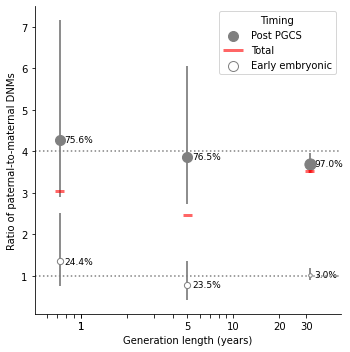

In [137]:
f,ax = plt.subplots(figsize=[5,5])

### Common styling ###
alpha_y_range = [0.6, 4.3]
g_x_range = [np.log10(0.5), np.log10(45)]
original_Gs = list(np.linspace(0.6,1,5)) + list(range(1,11)) + [20,30]
xlabels = ["" if g not in [1,5,10,20,30] else g for g in original_Gs]
log10_Gs = np.log10(original_Gs)


### DNM alphas ###

dnm_stages = pd.read_csv("../data/dnm_stages.csv")

total_paternal = dnm_stages.groupby("Species").apply(lambda x: x.Paternal.sum()).to_dict()
total_maternal = dnm_stages.groupby("Species").apply(lambda x: x.Maternal.sum()).to_dict()
species_ages = dnm_stages.set_index("Species")["Parental_age"].to_dict()

frac_ee = {}
for sp,df in dnm_stages.groupby("Species"):
    m_dnms, p_dnms = extraploate_parental_dnms(df)
    total_alpha = p_dnms/m_dnms
    all_df = pd.DataFrame([sp, p_dnms, m_dnms, p_dnms+m_dnms, "All", species_ages[sp]]).transpose()    
    all_df.columns = dnm_stages.columns
    dnm_stages = pd.concat([dnm_stages,all_df])
    ee = fraction_ee(df)
    frac_ee[sp] = ee

    
dnm_stages = dnm_stages.reset_index(drop=True)
dnm_stages = add_binomial_CIs(dnm_stages)
dnm_stages["Parental_age_log"] = np.log10(list(dnm_stages.Parental_age))
#dnm_stages = dodge_positions(dnm_stages, "Parental_age_log", "Stage", ["Early_embryonic","PostPGCS","All"], 0.03)
dnm_stages = dnm_stages.replace("Early_embryonic","Early embryonic").replace("PostPGCS","Post PGCS")

margin = 0.03
for sp,df in dnm_stages.groupby("Species"):
    
    all_alpha = df[df.Stage=="All"]["point"].values[0]
    ee_dnm = df[df.Stage=="Early embryonic"]["point"].values[0]
    postpgcs_dnm = df[df.Stage=="Post PGCS"]["point"].values[0]
    g = df[df.Stage=="Early embryonic"]["Parental_age_log"].values[0]
    
    ax.scatter(g, ee_dnm, c="white", edgecolor="gray", zorder=10, s=int(frac_ee[sp]*120)+10) 
    ax.annotate("{:.1f}%".format(frac_ee[sp]*100), xy=(g+margin, ee_dnm), va="center", fontsize=9)
    
    ax.scatter(g, postpgcs_dnm, c="gray", edgecolor="gray", zorder=10, s=int((1-frac_ee[sp])*120)+10)
    ax.annotate("{:.1f}%".format((1-frac_ee[sp])*100), xy=(g+margin, postpgcs_dnm), va="center", fontsize=9)
    
    xmin = df.Parental_age_log.values[0] - margin
    xmax = df.Parental_age_log.values[0] + margin
    ax.hlines(y=all_alpha, xmin=xmin, xmax=xmax,
              color="red", zorder=10, linewidth=3, alpha=0.6)
    
    if sp=="Homo_sapiens":
        ax.scatter(1e3,1e3,s=100,c="gray", edgecolor="gray", label="Post PGCS")
        ax.hlines(y=all_alpha, xmin=xmin+(margin/2), xmax=xmax-(margin/2),color="red", zorder=10, linewidth=3, alpha=0.6, label="Total")
        ax.scatter(1e3,1e3,s=100,c="white", edgecolor="gray", label="Early embryonic")
        
    

for i,r in dnm_stages[dnm_stages.Stage!="All"].iterrows():
    ax.vlines(x = r.Parental_age_log, ymin = r.low, ymax = r.high,color="dimgray")
       
ax.legend(title="Timing")
ax.axhline(y=4, color="gray",linestyle="dotted",label="")
ax.axhline(y=1, color="gray",linestyle="dotted",label="")

ax.set_xlim([g_x_range[0], g_x_range[1]+0.05])
ax.set_ylim([0.08595132252846266, 7.496652048736973])
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation length (years)")
ax.set_ylabel("Ratio of paternal-to-maternal DNMs")
plt.tight_layout()
sns.despine()

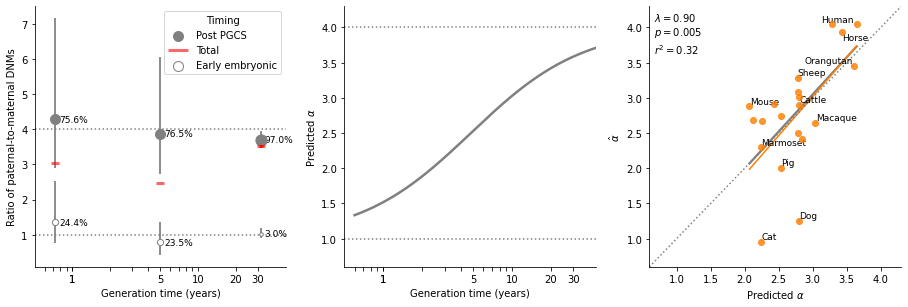

In [177]:
f,axs0 = plt.subplots(1, 3, figsize=[12.5,4.16], constrained_layout=True)
axs = axs0.reshape(-1)

### Common styling ###
alpha_y_range = [0.6, 4.3]
g_x_range = [np.log10(0.5), np.log10(45)]
original_Gs = list(np.linspace(0.6,1,5)) + list(range(1,11)) + [20,30]
xlabels = ["" if g not in [1,5,10,20,30] else g for g in original_Gs]
log10_Gs = np.log10(original_Gs)


### DNM alphas ###

ax = axs[0]

dnm_stages = pd.read_csv("../data/dnm_stages.csv")

total_paternal = dnm_stages.groupby("Species").apply(lambda x: x.Paternal.sum()).to_dict()
total_maternal = dnm_stages.groupby("Species").apply(lambda x: x.Maternal.sum()).to_dict()
species_ages = dnm_stages.set_index("Species")["Parental_age"].to_dict()

frac_ee = {}
for sp,df in dnm_stages.groupby("Species"):
    m_dnms, p_dnms = extraploate_parental_dnms(df)
    total_alpha = p_dnms/m_dnms
    all_df = pd.DataFrame([sp, p_dnms, m_dnms, p_dnms+m_dnms, "All", species_ages[sp]]).transpose()    
    all_df.columns = dnm_stages.columns
    dnm_stages = pd.concat([dnm_stages,all_df])
    ee = fraction_ee(df)
    frac_ee[sp] = ee

    
dnm_stages = dnm_stages.reset_index(drop=True)
dnm_stages = add_binomial_CIs(dnm_stages)
dnm_stages["Parental_age_log"] = np.log10(list(dnm_stages.Parental_age))
#dnm_stages = dodge_positions(dnm_stages, "Parental_age_log", "Stage", ["Early_embryonic","PostPGCS","All"], 0.03)
dnm_stages = dnm_stages.replace("Early_embryonic","Early embryonic").replace("PostPGCS","Post PGCS")

margin = 0.03
for sp,df in dnm_stages.groupby("Species"):
    
    all_alpha = df[df.Stage=="All"]["point"].values[0]
    ee_dnm = df[df.Stage=="Early embryonic"]["point"].values[0]
    postpgcs_dnm = df[df.Stage=="Post PGCS"]["point"].values[0]
    g = df[df.Stage=="Early embryonic"]["Parental_age_log"].values[0]
    
    ax.scatter(g, ee_dnm, c="white", edgecolor="gray", zorder=10, s=int(frac_ee[sp]*120)+10) 
    ax.annotate("{:.1f}%".format(frac_ee[sp]*100), xy=(g+margin, ee_dnm), va="center", fontsize=9)
    
    ax.scatter(g, postpgcs_dnm, c="gray", edgecolor="gray", zorder=10, s=int((1-frac_ee[sp])*120)+10)
    ax.annotate("{:.1f}%".format((1-frac_ee[sp])*100), xy=(g+margin, postpgcs_dnm), va="center", fontsize=9)
    
    xmin = df.Parental_age_log.values[0] - margin
    xmax = df.Parental_age_log.values[0] + margin
    ax.hlines(y=all_alpha, xmin=xmin, xmax=xmax,
              color="red", zorder=10, linewidth=3, alpha=0.6)
    
    if sp=="Homo_sapiens":
        ax.scatter(1e3,1e3,s=100,c="gray", edgecolor="gray", label="Post PGCS")
        ax.hlines(y=all_alpha, xmin=xmin+(margin/2), xmax=xmax-(margin/2),color="red", zorder=10, linewidth=3, alpha=0.6, label="Total")
        ax.scatter(1e3,1e3,s=100,c="white", edgecolor="gray", label="Early embryonic")
        
    

for i,r in dnm_stages[dnm_stages.Stage!="All"].iterrows():
    ax.vlines(x = r.Parental_age_log, ymin = r.low, ymax = r.high,color="dimgray")
       
ax.legend(title="Timing")
ax.axhline(y=4, color="gray",linestyle="dotted",label="")
ax.axhline(y=1, color="gray",linestyle="dotted",label="")

ax.set_xlim([g_x_range[0], g_x_range[1]+0.05])
ax.set_ylim([0.08595132252846266, 7.496652048736973])
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation time (years)")
ax.set_ylabel("Ratio of paternal-to-maternal DNMs")

### Model ###

ax=axs[1]
rates_df = pd.read_csv("../data/subrate_div_data.txt",sep="\t")
yearly_rates = rates_df[rates_df.Subset=="Mammals"].sort_values(by="MutPerYearUCSC", ascending=False).set_index("Species")["MutPerYearUCSC"].to_dict()
yearly_rates = {k:v/1e6 for k,v in yearly_rates.items()}
mammal_traits = data["Mammals"]["xy"]
log_gen_times = mammal_traits[mammal_traits.experiment=="GenerationLength_d"].set_index("Species")["xvar"].to_dict()
gen_times = {k:(10**v) for k,v in log_gen_times.items()}

# Parameters
n_e = 3/3e9
Gs = list(np.linspace(0.6, 1, 1000)) + list(np.linspace(1, 45, 1000))
n_partitions = 10
species = list(yearly_rates.keys())

# Find max/min parental age effects
mu_ms = []
paternal_effects = {}
for i,sp in enumerate(species):
    mu_f, mu_m = get_paternal_age_effects(yearly_rates[sp], gen_times[sp], gen_times[sp], n_e, 4)
    paternal_effects[sp] = mu_m
    mu_ms.append(mu_m)
mu_m_space = [2]
    
# Plot parental age effect space
cmap = plt.get_cmap('Purples_r')
new_cmap = truncate_colormap(cmap, 0.1, 0.75)
norm = mplt.colors.Normalize(vmin=min(mu_ms), vmax=max(mu_ms), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=new_cmap)
#curves = [ax.plot(np.log10(Gs), [predict_alpha(mu_m/4, mu_m, g, g, n_e) for g in Gs],c=mapper.to_rgba(mu_m)) for i,mu_m in enumerate(mu_m_space)]
#toy_points = ax.scatter([100]*n_partitions, mu_m_space, c=mu_m_space, cmap=new_cmap) 
mu_m = 2.5/3e9
ax.plot(np.log10(Gs), [predict_alpha(mu_m/4, mu_m, g, g, n_e) for g in Gs], color="gray",linewidth=2.5)
    
# Vertial lines
ax.axhline(y=4, linestyle="dotted", color="gray")
ax.axhline(y=1, linestyle="dotted", color="gray")

# Styling
#cbar = plt.colorbar(toy_points, ax=axs[1:2],aspect=70,shrink=0.8)
#cbar.set_label(r"Paternal age effect bp$^{-1}$ yr$^{-1}$")

ax.set_xlim(g_x_range)
ax.set_ylim(alpha_y_range)
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation time (years)")
ax.set_ylabel(r"Predicted $\alpha$")

### Predicted vs XA alpha ###

ax = axs[2]

pred_alpha = mammal_traits[mammal_traits.experiment=="predicted_alpha"].reset_index(drop=True)

# Plot pgls and scatter
group = "Mammals"
sns.regplot(data=pred_alpha,x="xvar",y="yvar",ax=ax,scatter=False,color="gray",ci=None)
stats = plot_pgls(data, group, "predicted_alpha", "pgls_ml", ax, palette["Mammals"], True, 0.8, True, False)
identity_line(ax,color="gray", ls="dotted")
colors = [mapper.to_rgba(paternal_effects[sp]) for sp in pred_alpha.Species]

# Species text
selected_species = ["Homo_sapiens","Equus_caballus","Pongo_abelii","Ovis_aries","Canis_lupus_familiaris","Felis_catus","Macaca_mulatta","Mus_musculus","Callithrix_jacchus","Bos_taurus","Sus_scrofa"]
plot_sp_text(data, group, "predicted_alpha", sp2common, selected_species, ax, ["black"]*len(colors))

# Stats
ax.text(s = r"$\lambda={:.2f}$".format(stats["lambda"]) + "\n" + r"$p={:.3f}$".format(stats["pval"]) + "\n" + r"$r^2={:.2f}$".format(stats["r2"]),
        x=0.02, y=0.98, va="top",ha="left", transform=ax.transAxes,color="black")

# X axis
ax.set_xlabel(r"Predicted $\alpha$")

# Y axis
ax.set_ylabel(r"$\hat{\alpha}$")

# Style
#range_axes = [0.8,4.5]
ax.set_xlim(alpha_y_range)
ax.set_ylim(alpha_y_range)


sns.despine()
#plt.tight_layout()
f.savefig("pdfs/Figure_4.panels.pdf")

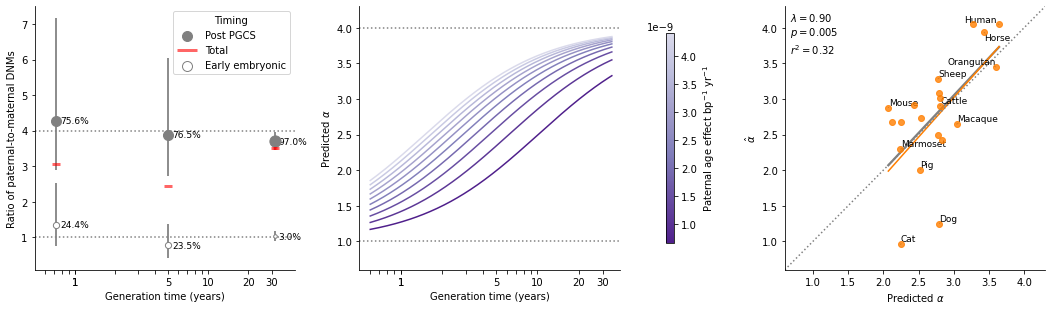

In [153]:
f,axs0 = plt.subplots(1, 3, figsize=[14.5,4.2],constrained_layout=True)
axs = axs0.reshape(-1)

### Common styling ###
alpha_y_range = [0.6, 4.3]
g_x_range = [np.log10(0.5), np.log10(40)]
original_Gs = list(np.linspace(0.6,1,5)) + list(range(1,11)) + [20,30]
xlabels = ["" if g not in [1,5,10,20,30] else g for g in original_Gs]
log10_Gs = np.log10(original_Gs)


### DNM alphas ###

ax = axs[0]

dnm_stages = pd.read_csv("../data/dnm_stages.csv")

total_paternal = dnm_stages.groupby("Species").apply(lambda x: x.Paternal.sum()).to_dict()
total_maternal = dnm_stages.groupby("Species").apply(lambda x: x.Maternal.sum()).to_dict()
species_ages = dnm_stages.set_index("Species")["Parental_age"].to_dict()

frac_ee = {}
for sp,df in dnm_stages.groupby("Species"):
    m_dnms, p_dnms = extraploate_parental_dnms(df)
    total_alpha = p_dnms/m_dnms
    all_df = pd.DataFrame([sp, p_dnms, m_dnms, p_dnms+m_dnms, "All", species_ages[sp]]).transpose()    
    all_df.columns = dnm_stages.columns
    dnm_stages = pd.concat([dnm_stages,all_df])
    ee = fraction_ee(df)
    frac_ee[sp] = ee

    
dnm_stages = dnm_stages.reset_index(drop=True)
dnm_stages = add_binomial_CIs(dnm_stages)
dnm_stages["Parental_age_log"] = np.log10(list(dnm_stages.Parental_age))
#dnm_stages = dodge_positions(dnm_stages, "Parental_age_log", "Stage", ["Early_embryonic","PostPGCS","All"], 0.03)
dnm_stages = dnm_stages.replace("Early_embryonic","Early embryonic").replace("PostPGCS","Post PGCS")

margin = 0.03
for sp,df in dnm_stages.groupby("Species"):
    
    all_alpha = df[df.Stage=="All"]["point"].values[0]
    ee_dnm = df[df.Stage=="Early embryonic"]["point"].values[0]
    postpgcs_dnm = df[df.Stage=="Post PGCS"]["point"].values[0]
    g = df[df.Stage=="Early embryonic"]["Parental_age_log"].values[0]
    
    ax.scatter(g, ee_dnm, c="white", edgecolor="gray", zorder=10, s=int(frac_ee[sp]*120)+10) 
    ax.annotate("{:.1f}%".format(frac_ee[sp]*100), xy=(g+margin, ee_dnm), va="center", fontsize=9)
    
    ax.scatter(g, postpgcs_dnm, c="gray", edgecolor="gray", zorder=10, s=int((1-frac_ee[sp])*120)+10)
    ax.annotate("{:.1f}%".format((1-frac_ee[sp])*100), xy=(g+margin, postpgcs_dnm), va="center", fontsize=9)
    
    xmin = df.Parental_age_log.values[0] - margin
    xmax = df.Parental_age_log.values[0] + margin
    ax.hlines(y=all_alpha, xmin=xmin, xmax=xmax,
              color="red", zorder=10, linewidth=3, alpha=0.6)
    
    if sp=="Homo_sapiens":
        ax.scatter(1e3,1e3,s=100,c="gray", edgecolor="gray", label="Post PGCS")
        ax.hlines(y=all_alpha, xmin=xmin+(margin/2), xmax=xmax-(margin/2),color="red", zorder=10, linewidth=3, alpha=0.6, label="Total")
        ax.scatter(1e3,1e3,s=100,c="white", edgecolor="gray", label="Early embryonic")
        
    

for i,r in dnm_stages[dnm_stages.Stage!="All"].iterrows():
    ax.vlines(x = r.Parental_age_log, ymin = r.low, ymax = r.high,color="dimgray")
       
ax.legend(title="Timing")
ax.axhline(y=4, color="gray",linestyle="dotted",label="")
ax.axhline(y=1, color="gray",linestyle="dotted",label="")

ax.set_xlim([g_x_range[0], g_x_range[1]+0.05])
ax.set_ylim([0.08595132252846266, 7.496652048736973])
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation time (years)")
ax.set_ylabel("Ratio of paternal-to-maternal DNMs")

### Model ###

ax=axs[1]
rates_df = pd.read_csv("../data/subrate_div_data.txt",sep="\t")
yearly_rates = rates_df[rates_df.Subset=="Mammals"].sort_values(by="MutPerYearUCSC", ascending=False).set_index("Species")["MutPerYearUCSC"].to_dict()
yearly_rates = {k:v/1e6 for k,v in yearly_rates.items()}
mammal_traits = data["Mammals"]["xy"]
log_gen_times = mammal_traits[mammal_traits.experiment=="GenerationLength_d"].set_index("Species")["xvar"].to_dict()
gen_times = {k:(10**v) for k,v in log_gen_times.items()}

# Parameters
n_e = 5/3e9
Gs = list(np.linspace(0.6, 1, 1000)) + list(np.linspace(1, 35, 1000))
n_partitions = 10
species = list(yearly_rates.keys())

# Find max/min parental age effects
mu_ms = []
paternal_effects = {}
for i,sp in enumerate(species):
    mu_f, mu_m = get_paternal_age_effects(yearly_rates[sp], gen_times[sp], gen_times[sp], n_e, 4)
    paternal_effects[sp] = mu_m
    mu_ms.append(mu_m)
mu_m_space = np.linspace(min(mu_ms),max(mu_ms),n_partitions)
    
# Plot parental age effect space
cmap = plt.get_cmap('Purples_r')
new_cmap = truncate_colormap(cmap, 0.1, 0.75)
norm = mplt.colors.Normalize(vmin=min(mu_ms), vmax=max(mu_ms), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=new_cmap)
curves = [ax.plot(np.log10(Gs), [predict_alpha(mu_m/4, mu_m, g, g, n_e) for g in Gs],c=mapper.to_rgba(mu_m)) for i,mu_m in enumerate(mu_m_space)]
toy_points = ax.scatter([100]*n_partitions, mu_m_space, c=mu_m_space, cmap=new_cmap) 
    
# Vertial lines
ax.axhline(y=4, linestyle="dotted", color="gray")
ax.axhline(y=1, linestyle="dotted", color="gray")

# Styling
cbar = plt.colorbar(toy_points, ax=axs[1:2],aspect=70,shrink=0.8)
cbar.set_label(r"Paternal age effect bp$^{-1}$ yr$^{-1}$")

ax.set_xlim(g_x_range)
ax.set_ylim(alpha_y_range)
ax.set_xticks(log10_Gs)
ax.set_xticklabels(xlabels)
ax.set_xlabel(r"Generation time (years)")
ax.set_ylabel(r"Predicted $\alpha$")

### Predicted vs XA alpha ###

ax = axs[2]

pred_alpha = mammal_traits[mammal_traits.experiment=="predicted_alpha"].reset_index(drop=True)

# Plot pgls and scatter
group = "Mammals"
sns.regplot(data=pred_alpha,x="xvar",y="yvar",ax=ax,scatter=False,color="gray",ci=None)
stats = plot_pgls(data, group, "predicted_alpha", "pgls_ml", ax, palette["Mammals"], True, 0.8, True, False)
identity_line(ax,color="gray", ls="dotted")
colors = [mapper.to_rgba(paternal_effects[sp]) for sp in pred_alpha.Species]

# Species text
selected_species = ["Homo_sapiens","Equus_caballus","Pongo_abelii","Ovis_aries","Canis_lupus_familiaris","Felis_catus","Macaca_mulatta","Mus_musculus","Callithrix_jacchus","Bos_taurus","Sus_scrofa"]
plot_sp_text(data, group, "predicted_alpha", sp2common, selected_species, ax, ["black"]*len(colors))

# Stats
ax.text(s = r"$\lambda={:.2f}$".format(stats["lambda"]) + "\n" + r"$p={:.3f}$".format(stats["pval"]) + "\n" + r"$r^2={:.2f}$".format(stats["r2"]),
        x=0.02, y=0.98, va="top",ha="left", transform=ax.transAxes,color="black")

# X axis
ax.set_xlabel(r"Predicted $\alpha$")

# Y axis
ax.set_ylabel(r"$\hat{\alpha}$")

# Style
#range_axes = [0.8,4.5]
ax.set_xlim(alpha_y_range)
ax.set_ylim(alpha_y_range)


sns.despine()
#plt.tight_layout()

#f.savefig("pdfs/Figure_4.panels.pdf")